# Packages

In [27]:
# from model import FinalModel
# from data import randomSubset, prepare_data
# from inference import test_metrics

# hydroDL module by Kuai Fang
from hydroDL.data import dbVeg
from hydroDL.data import DataModel
from hydroDL.master import dataTs2Range
from hydroDL import kPath

import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
from torch import nn
import torch
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
# import wandb

import json
import os
import argparse
import shutil
import random
import time

import math
import pdb

# Prepare dataset

In [28]:
rho = 45 # init rho
dataName = 'singleDaily-modisgrid-new-const' # init dataName
# importlib.reload(hydroDL.data.dbVeg) # reimport library
df = dbVeg.DataFrameVeg(dataName) # create DataFrameVeg class 
dm = DataModel(X=df.x, XC=df.xc, Y=df.y) # (?) create DataModel class (contains many confusing functions) 
siteIdLst = df.siteIdLst # get site list
dm.trans(mtdDefault='minmax') # (?) some sort of data normalization
dataTup = dm.getData() # get x, xc, y, and yc
dataEnd, (iInd, jInd) = dataTs2Range(dataTup, rho, returnInd=True) # get data into form (# LFMC, 91 day window, varX) 
x, xc, y, yc = dataEnd # data from dataTs2Range
iInd = np.array(iInd)
jInd = np.array(jInd)

In [29]:
print(f"There are {yc.shape[0]} total observations.")
print(f"There are {df.y.shape[1]} total sites.")

There are 10235 total observations.
There are 335 total sites.


In [30]:
# get indices of variables of interest
varS = ['VV', 'VH', 'vh_vv']
# varL = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'ndvi', 'ndwi', 'nirv']
varM = ["MCD43A4_b{}".format(x) for x in range(1, 8)]
iS = [df.varX.index(var) for var in varS]
# iL = [df.varX.index(var) for var in varL]
iM = [df.varX.index(var) for var in varM]

# for each satellite, for each LFMC data point
# create a list of days in the 91 day window that have data

# nMat -- (# obs, # satellites)
# nMat contains # of days each satellite has data for
pSLst, pMLst = list(), list()
ns = yc.shape[0]
nMat = np.zeros([yc.shape[0], 2])
for k in range(nMat.shape[0]):
    tempS = x[:, k, iS] # x (rho, LFMC, varX) 
    pS = np.where(~np.isnan(tempS).any(axis=1))[0]
    # tempL = x[:, k, iL] # x (rho, LFMC, varX) 
    # pL = np.where(~np.isnan(tempL).any(axis=1))[0]
    tempM = x[:, k, iM] # x (rho, LFMC, varX) 
    pM = np.where(~np.isnan(tempM).any(axis=1))[0]
    pSLst.append(pS)
    # pLLst.append(pL)
    pMLst.append(pM)
    nMat[k, :] = [len(pS), len(pM)]

In [31]:
num_obs = (nMat == 0).any(axis=1).sum()
print(f"There are {num_obs} obsevations with no data for at least 1 satellite.")

There are 164 obsevations with no data for at least 1 satellite.


In [32]:
# only keep data if there is at least 1 day of data for 
# each satellite
indKeep = np.where((nMat > 0).all(axis=1))[0]
x = x[:, indKeep, :]
xc = xc[indKeep, :]
yc = yc[indKeep, :]
nMat = nMat[indKeep, :]
pSLst = [pSLst[k] for k in indKeep]
# pLLst = [pLLst[k] for k in indKeep]
pMLst = [pMLst[k] for k in indKeep]
iInd = iInd[indKeep]
jInd = jInd[indKeep] 

# # update from just list of sites to sites per datapoint
siteIdLst = [siteIdLst[k] for k in jInd] 

jSite, count = np.unique(jInd, return_counts=True) # sites, # of times site appears
countAry = np.array([[x, y] for y, x in sorted(zip(count, jSite))]) # rearrange

In [33]:
print(f"After removing obsevations that have no data for at least 1 satellite:")
print(f"- There are {yc.shape[0]} total observations.")
print(f"- There are {len(jSite)} sites.")

After removing obsevations that have no data for at least 1 satellite:
- There are 10071 total observations.
- There are 312 sites.


In [34]:
# remove points not in target states
import geopandas as gpd
from shapely.geometry import Point

lon_list = df.lon[countAry[:, 0]]
lat_list = df.lat[countAry[:, 0]]
points = [Point(lon, lat) for lon, lat in zip(lon_list, lat_list)]
points_gdf = gpd.GeoDataFrame({'site': countAry[:, 0]}, geometry=points, crs='EPSG:4326')

states_path = os.path.join(kPath.dirVeg, "shapefiles", "us", "States_shapefile.shp")
states_gdf = gpd.read_file(states_path)
states_gdf = states_gdf[['State_Code', 'State_Name', 'geometry']]

target_states = ['WASHINGTON', 'OREGON', 'IDAHO', 'MONTANA', 'WYOMING', 'CALIFORNIA', 'NEVADA', 'UTAH', 'COLORADO', 'ARIZONA', 'NEW MEXICO', 'TEXAS'] 
target_state_boundary = states_gdf[states_gdf['State_Name'].isin(target_states)]
sites_within_states = np.array(gpd.sjoin(points_gdf, target_state_boundary).site)

countAry = countAry[np.isin(countAry[:, 0], sites_within_states)]

In [35]:
print(f"There are {len(jSite) - len(sites_within_states)} sites not in the Western US.")

There are 7 sites not in the Western US.


In [36]:
print("After removing sites not in the Western US:")
print(f"- The are {np.isin(jInd, sites_within_states).sum()} observations.")
print(f"- There are {countAry.shape[0]} sites.")

After removing sites not in the Western US:
- The are 9975 observations.
- There are 305 sites.


# Create/save dataset split based on threshold

In [37]:
THRESHOLD = 30
nRm = sum(countAry[:, 1] < THRESHOLD)
indSiteOverThresh = countAry[nRm:, 0].astype(int) 
indSiteUnderThresh = countAry[:nRm, 0].astype(int) 
indSiteOverThresh = np.sort(indSiteOverThresh)
indSiteUnderThresh = np.sort(indSiteUnderThresh)

In [38]:
num_sites = len(indSiteOverThresh)
num_obs = len(np.where(np.isin(jInd, indSiteOverThresh))[0].tolist())

print("When looking at sites with more than 30 observations:")
print(f"- There are {num_obs} observations.")
print(f"- There are {num_sites} sites.")

When looking at sites with more than 30 observations:
- There are 7963 observations.
- There are 159 sites.


In [39]:
num_sites = len(indSiteUnderThresh)
num_obs = len(np.where(np.isin(jInd, indSiteUnderThresh))[0].tolist())

print("When looking at sites with less than 30 observations:")
print(f"- There are {num_obs} observations.")
print(f"- There are {num_sites} sites.")

When looking at sites with less than 30 observations:
- There are 2012 observations.
- There are 146 sites.


In [40]:
# quality
thresh = 0.4

# get land cover percentages for quality sites
lc_idx = [df.varXC.index(var) for var in df.varXC[-6:]]
lc_pct = df.xc[:, lc_idx]
lc_pct = lc_pct[indSiteOverThresh]

top_lc = np.argmax(lc_pct, axis=1)
land_cover_array_over = np.stack((indSiteOverThresh, top_lc), axis=1)

In [41]:
mixed_site_idxs = np.where(np.max(lc_pct, axis=1) < thresh)
land_cover_array_over[mixed_site_idxs, 1] = 5

In [70]:
seed = 0

In [71]:
from sklearn.model_selection import StratifiedKFold
data = land_cover_array_over

dictSubset = dict()

# Separate the sites and land cover types
sites = data[:, 0]
land_cover_types = data[:, 1]

# Create StratifiedKFold instance
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Split the data
for k, (train_index, test_index) in enumerate(skf.split(sites, land_cover_types)):
    train_sites, test_sites = sites[train_index], sites[test_index]
    train_land_cover, test_land_cover = land_cover_types[train_index], land_cover_types[test_index]
    
    # print(f"Fold {k + 1}")
    # print(f"Train sites: {len(train_sites)}")
    # print(f"Test sites: {len(test_sites)}")
    # print()

    dictSubset['testSite_k{}5'.format(k)] = test_sites.tolist()
    dictSubset['trainSite_k{}5'.format(k)] = train_sites.tolist()

    indTest = np.where(np.isin(jInd, test_sites))[0]
    indTrain = np.where(np.isin(jInd, train_sites))[0]

    dictSubset['testInd_k{}5'.format(k)] = indTest.tolist()
    dictSubset['trainInd_k{}5'.format(k)] = indTrain.tolist()

dictSubset['testSite_underThresh'] = indSiteUnderThresh.tolist()
dictSubset['testInd_underThresh'] = np.where(np.isin(jInd, indSiteUnderThresh))[0].tolist()

/opt/anaconda3/envs/lfmc/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [72]:
saveFolder = os.path.join(kPath.dirVeg, 'model', 'attention', f'stratified_s{seed}')
if not os.path.exists(saveFolder):
    os.mkdir(saveFolder)
# dataFile = os.path.join(saveFolder, 'data.npz')
# np.savez_compressed(dataFile, x=x, xc=xc, y=yc, yc=yc, tInd=iInd, siteInd=jInd)
subsetFile = os.path.join(saveFolder, 'subset.json')
with open(subsetFile, 'w') as fp:
    json.dump(dictSubset, fp, indent=4)

In [77]:
dictSubset = dict()
for k in range(5):
    siteTest = indSiteOverThresh[k::5]
    siteTrain = np.setdiff1d(indSiteOverThresh, siteTest)
    indTest = np.where(np.isin(jInd, siteTest))[0]
    indTrain = np.where(np.isin(jInd, siteTrain))[0]
    dictSubset["testSite_k{}5".format(k)] = siteTest.tolist()
    dictSubset["trainSite_k{}5".format(k)] = siteTrain.tolist()
    dictSubset["testInd_k{}5".format(k)] = indTest.tolist()
    dictSubset["trainInd_k{}5".format(k)] = indTrain.tolist()

dictSubset['testSite_underThresh'] = indSiteUnderThresh.tolist()
dictSubset['testInd_underThresh'] = np.where(np.isin(jInd, indSiteUnderThresh))[0].tolist()

In [78]:
saveFolder = os.path.join(kPath.dirVeg, 'model', 'attention', f'random_s{seed}')
if not os.path.exists(saveFolder):
    os.mkdir(saveFolder)
# dataFile = os.path.join(saveFolder, 'data.npz')
# np.savez_compressed(dataFile, x=x, xc=xc, y=yc, yc=yc, tInd=iInd, siteInd=jInd)
subsetFile = os.path.join(saveFolder, 'subset.json')
with open(subsetFile, 'w') as fp:
    json.dump(dictSubset, fp, indent=4)

# Dataset Exploraiton

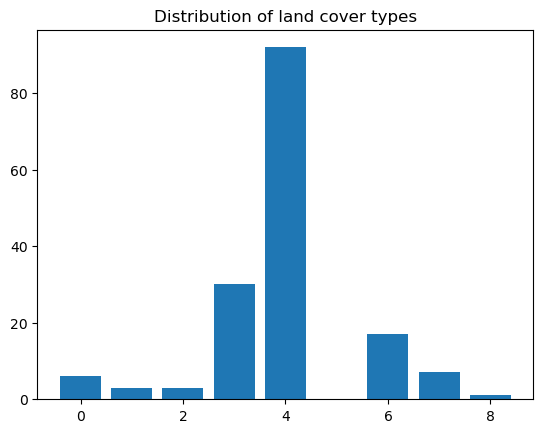

In [29]:
from matplotlib import pyplot as plt
types, counts = np.unique(land_cover_types, return_counts=True)
plt.bar(types, counts)
plt.title("Distribution of land cover types")
plt.show()

In [30]:
max(counts) / sum(counts)

0.5786163522012578

In [31]:
# lat_over = df.lat[indSiteOverThresh]
# lon_over = df.lon[indSiteOverThresh]

# lat_under = df.lat[indSiteUnderThresh]
# lon_under = df.lon[indSiteUnderThresh]

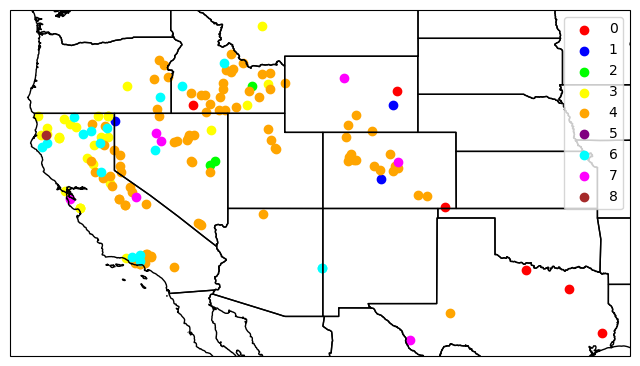

In [50]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

figM = plt.figure(figsize=(8, 6))
axM = figM.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

colors = ['#FF0000', '#0000FF', '#00FF00', '#FFFF00', '#FFA500', '#800080', '#00FFFF', '#FF00FF', '#A52A2A']

for i, color in enumerate(colors):
    sites = land_cover_array[land_cover_array[:, 1] == i][:, 0]
    axM.scatter(df.lon[sites], df.lat[sites], c=colors[i], label=str(i), transform=ccrs.PlateCarree())

axM.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black')

axM.legend()

plt.show()

In [ ]:
saveFolder = os.path.join(kPath.dirVeg, 'model', 'attention', 'stratified')
subsetFile = os.path.join(saveFolder, 'subset.json')
with open(subsetFile) as json_file:
    dictSubset = json.load(json_file)
print("loaded dictSubset")

loaded dictSubset


In [ ]:
for i in range(5):
    print(f"split {i}")
    test_sites = dictSubset[f'testSite_k{i}5']
    train_sites = dictSubset[f'trainSite_k{i}5']

    print(" percent train", len(train_sites) / (len(train_sites) + len(test_sites)))
    print(" percent test", len(test_sites) / (len(train_sites) + len(test_sites)))

split 0
 percent train 0.7987421383647799
 percent test 0.20125786163522014
split 1
 percent train 0.7987421383647799
 percent test 0.20125786163522014
split 2
 percent train 0.7987421383647799
 percent test 0.20125786163522014
split 3
 percent train 0.7987421383647799
 percent test 0.20125786163522014
split 4
 percent train 0.8050314465408805
 percent test 0.1949685534591195


In [ ]:
for i in range(5):
    print(f"split {i}")
    test_obs = dictSubset[f'testInd_k{i}5']
    train_obs = dictSubset[f'trainInd_k{i}5']

    print(" percent train", len(train_obs) / (len(train_obs) + len(test_obs)))
    print(" percent test", len(test_obs) / (len(train_obs) + len(test_obs)))

split 0
 percent train 0.8050985809368328
 percent test 0.19490141906316716
split 1
 percent train 0.7976893130729624
 percent test 0.20231068692703755
split 2
 percent train 0.7920381765666206
 percent test 0.20796182343337938
split 3
 percent train 0.793419565490393
 percent test 0.20658043450960692
split 4
 percent train 0.811754363933191
 percent test 0.188245636066809


# Dataset

In [ ]:
saveFolder = os.path.join(kPath.dirVeg, 'model', 'attention', 'states')
subsetFile = os.path.join(saveFolder, 'subset.json')
with open(subsetFile) as json_file:
    dictSubset = json.load(json_file)
print("loaded dictSubset")

loaded dictSubset


In [ ]:
[len(dictSubset[f"testSite_k{i}5"]) for i in range(5)]

[32, 32, 32, 32, 31]

In [ ]:
[len(dictSubset[f"trainSite_k{i}5"]) for i in range(5)]

[127, 127, 127, 127, 128]

In [ ]:
num_train_sites = np.array([len(dictSubset[f"testSite_k{i}5"]) for i in range(5)])
num_test_sites = np.array([len(dictSubset[f"trainSite_k{i}5"]) for i in range(5)])
num_train_sites + num_test_sites

array([158, 158, 158, 158, 158])

In [ ]:
len(dictSubset['testSite_underThresh'])

145

In [ ]:
quality_sites = np.concatenate([trainSite, testSite])
quality_site_counts = np.concatenate([countAry[countAry[:, 0] == site] for site in quality_sites])[:, 1]
poor_site_counts = np.concatenate([countAry[countAry[:, 0] == site] for site in poor_sites])[:, 1]

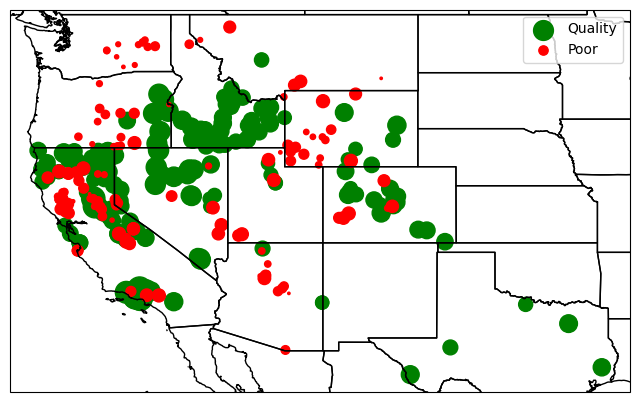

In [ ]:
trainSite = dictSubset["trainSite_k05"]
testSite = dictSubset["testSite_k05"]
poorSite = dictSubset['testSite_underThresh']

lat_set1 = np.concatenate([df.lat[trainSite], df.lat[testSite]])
lon_set1 = np.concatenate([df.lon[trainSite], df.lon[testSite]])
lat_set2 = df.lat[poorSite]
lon_set2 = df.lon[poorSite]

figM = plt.figure(figsize=(8, 6))
axM = figM.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot each set with different colors on the map
axM.scatter(lon_set1, lat_set1, s=quality_site_counts * 3, c='green', label='Quality', transform=ccrs.PlateCarree())
axM.scatter(lon_set2, lat_set2, s=poor_site_counts * 3, c='red', label='Poor', transform=ccrs.PlateCarree())

axM.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black')

axM.legend()
plt.show()

# More analsys (messy)

In [ ]:
len(N1)

159

In [ ]:
len(N2)

151

In [ ]:
N1_obs, N2_obs = 0, 0
for site in jInd:
    if site in N1: N1_obs += 1
    if site in N2: N2_obs += 1

In [ ]:
N1_obs

7909

In [ ]:
N2_obs

2061

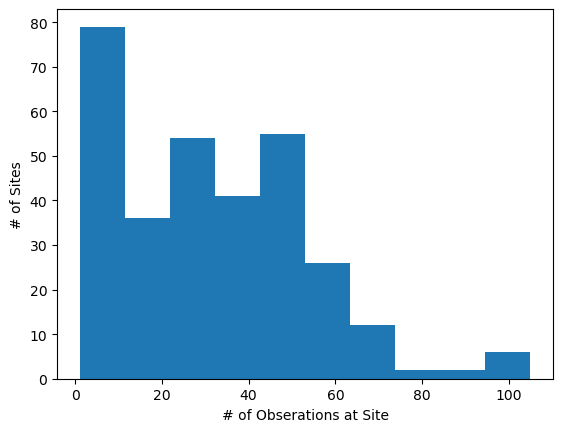

In [ ]:
plt.hist(count)
plt.xlabel("# of Obserations at Site")
plt.ylabel("# of Sites")
plt.show()

In [ ]:
iInd = iInd[indKeep]

In [ ]:
site_min_diff = {}
for site in np.unique(jInd):
    if site not in N1:
        continue
    dates = iInd[jInd == site]
    min_diff = float("inf")
    for i in range(1, len(dates)):
        min_diff = min(min_diff, dates[i] - dates[i - 1])
    if min_diff == float("inf"):
        continue
    site_min_diff[site] = min_diff

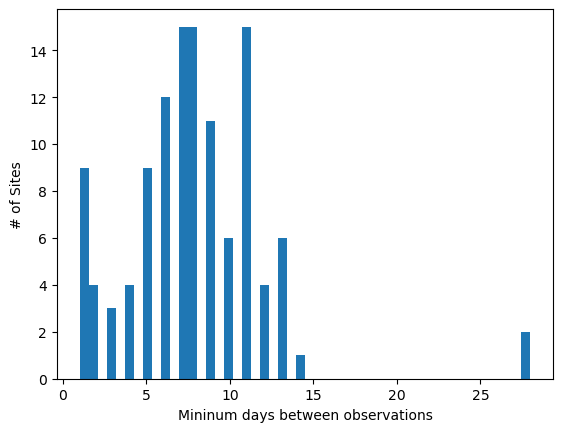

In [ ]:
min_data = [min_diff for site, min_diff in site_min_diff.items()]
plt.hist(min_data, bins=50)
plt.xlabel("Mininum days between observations")
plt.ylabel("# of Sites")
plt.show()

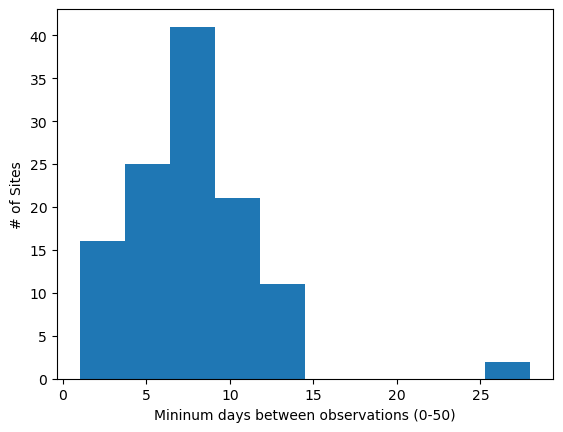

In [ ]:
min_data_100 = []
for d in min_data:
    if d < 50:
        min_data_100.append(d)
plt.hist(min_data_100, bins=10)
plt.xlabel("Mininum days between observations (0-50)")
plt.ylabel("# of Sites")
plt.show()

In [ ]:
site_med_diff = {}
for site in np.unique(jInd):
    if site not in N1:
        continue
    dates = iInd[jInd == site]
    diffs = []
    for i in range(1, len(dates)):
        diff = dates[i] - dates[i - 1]
        diffs.append(diff)
    site_med_diff[site] = np.median(diffs)

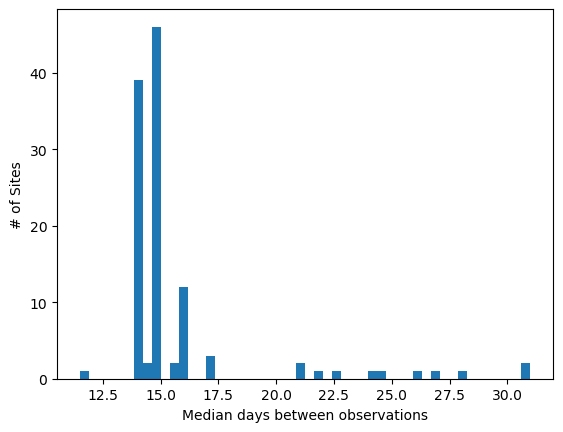

In [ ]:
med_data = [med_diff for site, med_diff in site_med_diff.items()]
plt.hist(med_data, bins=50)
plt.xlabel("Median days between observations")
plt.ylabel("# of Sites")
plt.show()

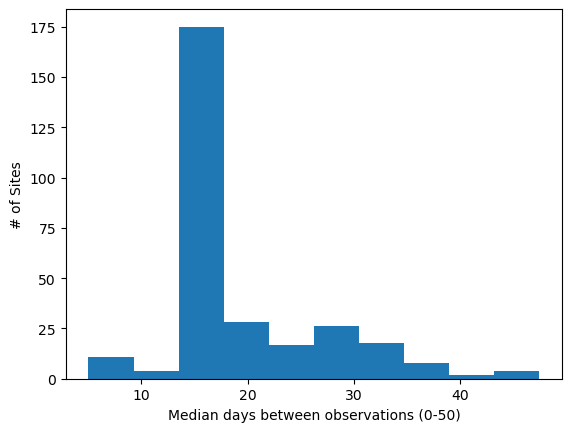

In [ ]:
med_data_100 = []
for d in med_data:
    if d < 50:
        med_data_100.append(d)
plt.hist(med_data_100, bins=10)
plt.xlabel("Median days between observations (0-50)")
plt.ylabel("# of Sites")
plt.show()

In [ ]:
site = np.random.choice(N2)
x = iInd[jInd == site]
y = yc[jInd == site]

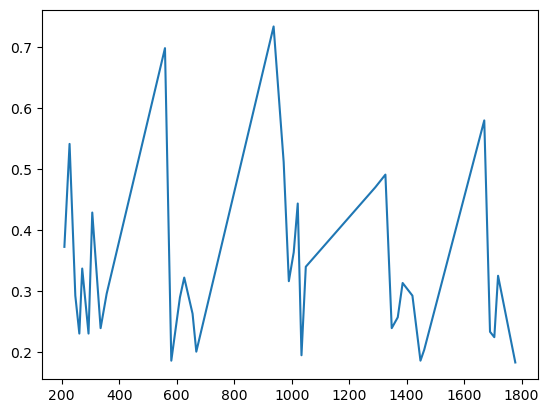

In [ ]:
plt.plot(x, y)

In [ ]:
sites_above_thresh = [df.siteIdLst[i] for i in N1]
sites_below_thresh = [df.siteIdLst[i] for i in N2]

In [ ]:
outFile = '/Users/andyhuynh/Documents/lfmc/providedData/NFMD/NFMD.csv'
# outFile = os.path.join(kPath.dirVeg, 'NFMD', 'NFMD.csv')
tabAll = pd.read_csv(outFile)
tabAll['Date'] = pd.to_datetime(tabAll['Date'], format='%Y-%m-%d')
crdFile = os.path.join(kPath.dirVeg, 'NFMD', 'NFMDsite.csv')
tabCrd = pd.read_csv(crdFile, index_col=0)

In [ ]:
tabAll[tabAll["siteId"].isin(siteSingle)]

In [ ]:
# find sites that are of single fuel
cntFuel = tabAll.groupby(['siteId'])['Fuel'].nunique().sort_values()
siteSingle = cntFuel[cntFuel == 1].index.tolist()
siteMix = cntFuel[cntFuel > 1].index.tolist()

In [ ]:
dict = {}
for site in siteSingle:
    tab = tabAll[tabAll['siteId'] == site]
    dates = tab.Date.tolist()
    dict[site] = len(dates)

In [ ]:
site = siteSingle[0]
tab = tabAll[tabAll['siteId'] == site]
dates = tab.Date.tolist()
print(site)
print(len(dates))

In [ ]:
jSite

In [ ]:
98 in count

In [ ]:
dict = {}
# loop thru each site
for site in siteSingle:
    tab = tabAll[tabAll['siteId'] == site]
    dates = tab.Date.tolist()
    # determine the min date diff and store in dictionary
    min_date_diff = float("inf")
    for i in range(len(dates)):
        for j in range(i + 1, len(dates)):
            date_diff = (dates[i] - dates[j]).days
            if date_diff < min_date_diff:
                min_date_diff = date_diff
    if min_date_diff == float("inf"):
        continue
    dict[site] = min_date_diff

In [ ]:
dists_above_thresh = []
for site, min_dist in dict.items():
    if site in sites_above_thresh:
        dists_above_thresh.append(min_dist)

In [ ]:
plt.hist(dists_above_thresh)
plt.xlabel("Minimum days between observations")
plt.ylabel("# of Sites")
plt.show()

In [ ]:
dists_below_thresh = []
for site, min_dist in dict.items():
    if site in sites_below_thresh:
        dists_below_thresh.append(min_dist)

In [ ]:
plt.hist(dists_below_thresh)
plt.xlabel("Minimum days between observations")
plt.ylabel("# of Sites")
plt.show()

In [ ]:
dict = {}
# loop thru each site
for site in siteSingle:
    tab = tabAll[tabAll['siteId'] == site]
    dates = tab.Date.tolist()
    # determine the min date diff and store in dictionary
    days_diff = []
    for i in range(len(dates)):
        for j in range(i + 1, len(dates)):
            days = (dates[i] - dates[j]).days
            days_diff.append(days)
    dict[site] = np.median(days_diff)

In [ ]:
dists_above_thresh = []
for site, min_dist in dict.items():
    if site in sites_above_thresh:
        dists_above_thresh.append(min_dist)

In [ ]:
plt.hist(dists_above_thresh)
plt.xlabel("Median days between observations")
plt.ylabel("# of Sites")
plt.show()

In [ ]:
dists_above_thresh = []
for site, min_dist in dict.items():
    if site in sites_above_thresh:
        dists_above_thresh.append(min_dist)

In [ ]:
plt.hist(dists_below_thresh)
plt.xlabel("Median days between observations")
plt.ylabel("# of Sites")
plt.show()